In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.insert(1, '../')
import velovae as vv
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
### write velocity encoder
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
import torch
from torch import nn
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def sign_concordance(GRN,ref_GRN):
    sign_GRN = np.sign(GRN)[GRN!=0]
    sign_ref_GRN = np.sign(ref_GRN)[ref_GRN!=0]
    score = sum(sign_GRN == sign_ref_GRN)
    return score
    


import scvelo as scv
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
import os
os.chdir("/gpfs/home/jw7078/VeloVI-RegVelo-time_bug_fix/")

from typing import Literal
import anndata as ad
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [3]:
model_path = f"checkpoints/"
figure_path = f"figures/"
data_path = f"data/"

In [4]:
adata = sc.read("/gpfs/home/jw7078/adata.h5ad")
adata.X = adata.layers["spliced"].copy()

del adata.layers["ambiguous"]
del adata.layers["matrix"]
del adata.layers["spanning"]

adata.obs.drop(
    ["Well_Plate", "plate", "MeanGreen530", "MeanRed585", "initial_size_unspliced", "initial_size_spliced", "initial_size"],
    axis=1,
    inplace=True
)

adata.var_names = adata.var["name"].values
adata.var.drop(adata.var.columns, axis=1, inplace=True)

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["fucci_time"], bins=5, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["fucci_time"], q=5, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["fucci_time"] / adata.obs["fucci_time"].max() * 2 * np.pi

In [5]:
n_gene = 2000
vv.preprocess(adata, n_gene)

Filtered out 8558 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.


In [6]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0')

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 422 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.40, 0.3647171152762675), (0.60, 0.8453713332689661)
(0.31, 0.33015548753693574), (0.69, 0.8306653532286565)
(0.82, 0.9428324465714703), (0.18, 0.3166697155694544)
KS-test result: [0. 0. 0.]
Initial induction: 1436, repression: 564/2000


In [7]:
gene_plot = ["Gng12"]

config = {

}
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=gene_plot,
          embed='umap')
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="velovae.h5ad")

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 7, test iteration: 12
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1146 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.031
Average Set Size: 23
*********     Round 1: Early Stop Triggered at epoch 1118.    *********
Change in noise variance: 0.4427
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1134.    *********
Change in noise variance: 0.0021
Change in x0: 0.6150
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1143.    *********
Change in noise variance: 0.0004
Change in x0: 0.5064
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1152.    *********
Change in noise variance: 0.0000
Change in x0: 0.4183
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1161.    *********
Change in noise variance: 0.0000
Change in x0: 0.3765
*********             Velocity Refinement Round 

In [8]:

torch.manual_seed(2022)
np.random.seed(2022)
rate_prior = {
    'alpha': (0.0, 1.0),
    'beta': (0.0, 0.5),
    'gamma': (0.0, 0.5)
}
full_vb = vv.VAE(adata, 
                 tmax=20, 
                 dim_z=5, 
                 device='cuda:0',
                 full_vb=True,
                 rate_prior=rate_prior)

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 422 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.40, 0.3647171152762675), (0.60, 0.8453713332689661)
(0.31, 0.33015548753693574), (0.69, 0.8306653532286565)
(0.82, 0.9428324465714703), (0.18, 0.3166697155694544)
KS-test result: [0. 0. 0.]
Initial induction: 1436, repression: 564/2000


In [9]:
full_vb.train(adata,
              plot=False,
              gene_plot=gene_plot,
              embed="umap")
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name="fullvb.h5ad")

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 7, test iteration: 12
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1146 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 23
*********     Round 1: Early Stop Triggered at epoch 1099.    *********
Change in noise variance: 0.4451
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1108.    *********
Change in noise variance: 0.0021
Change in x0: 0.4085
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1117.    *********
Change in noise variance: 0.0004
Change in x0: 0.3441
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1126.    *********
Change in noise variance: 0.0000
Change in x0: 0.3318
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1135.    *********
Change in noise variance: 0.0000
Change in x0: 0.2940
*********             Velocity Refinement Round 

Computing velocity embedding using scVelo
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 1146 cells, 2000 genes
---   Plotting  Results   ---
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


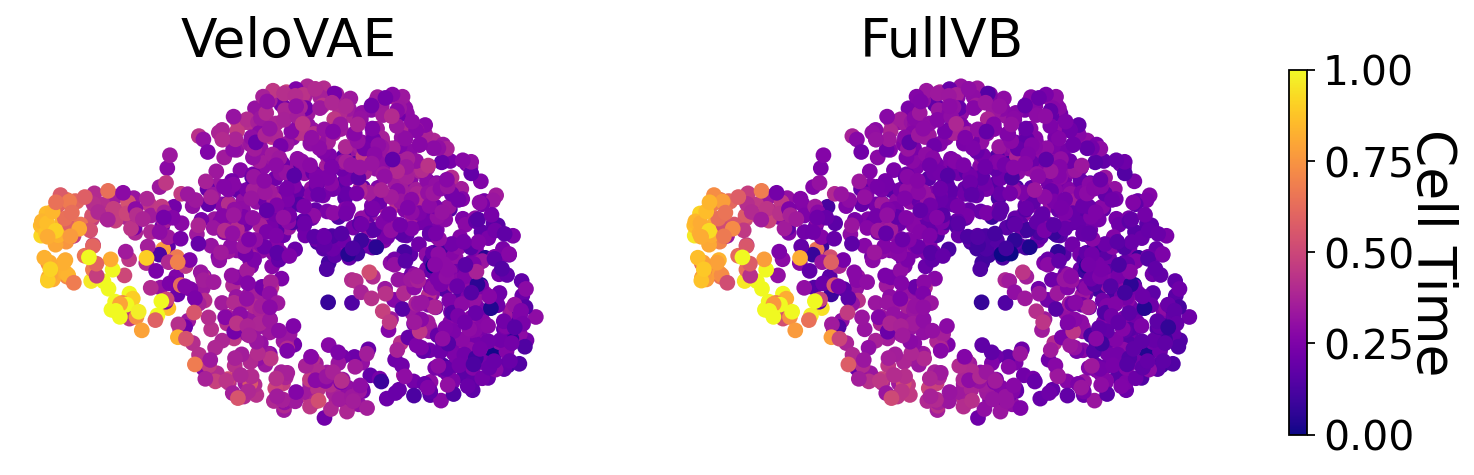

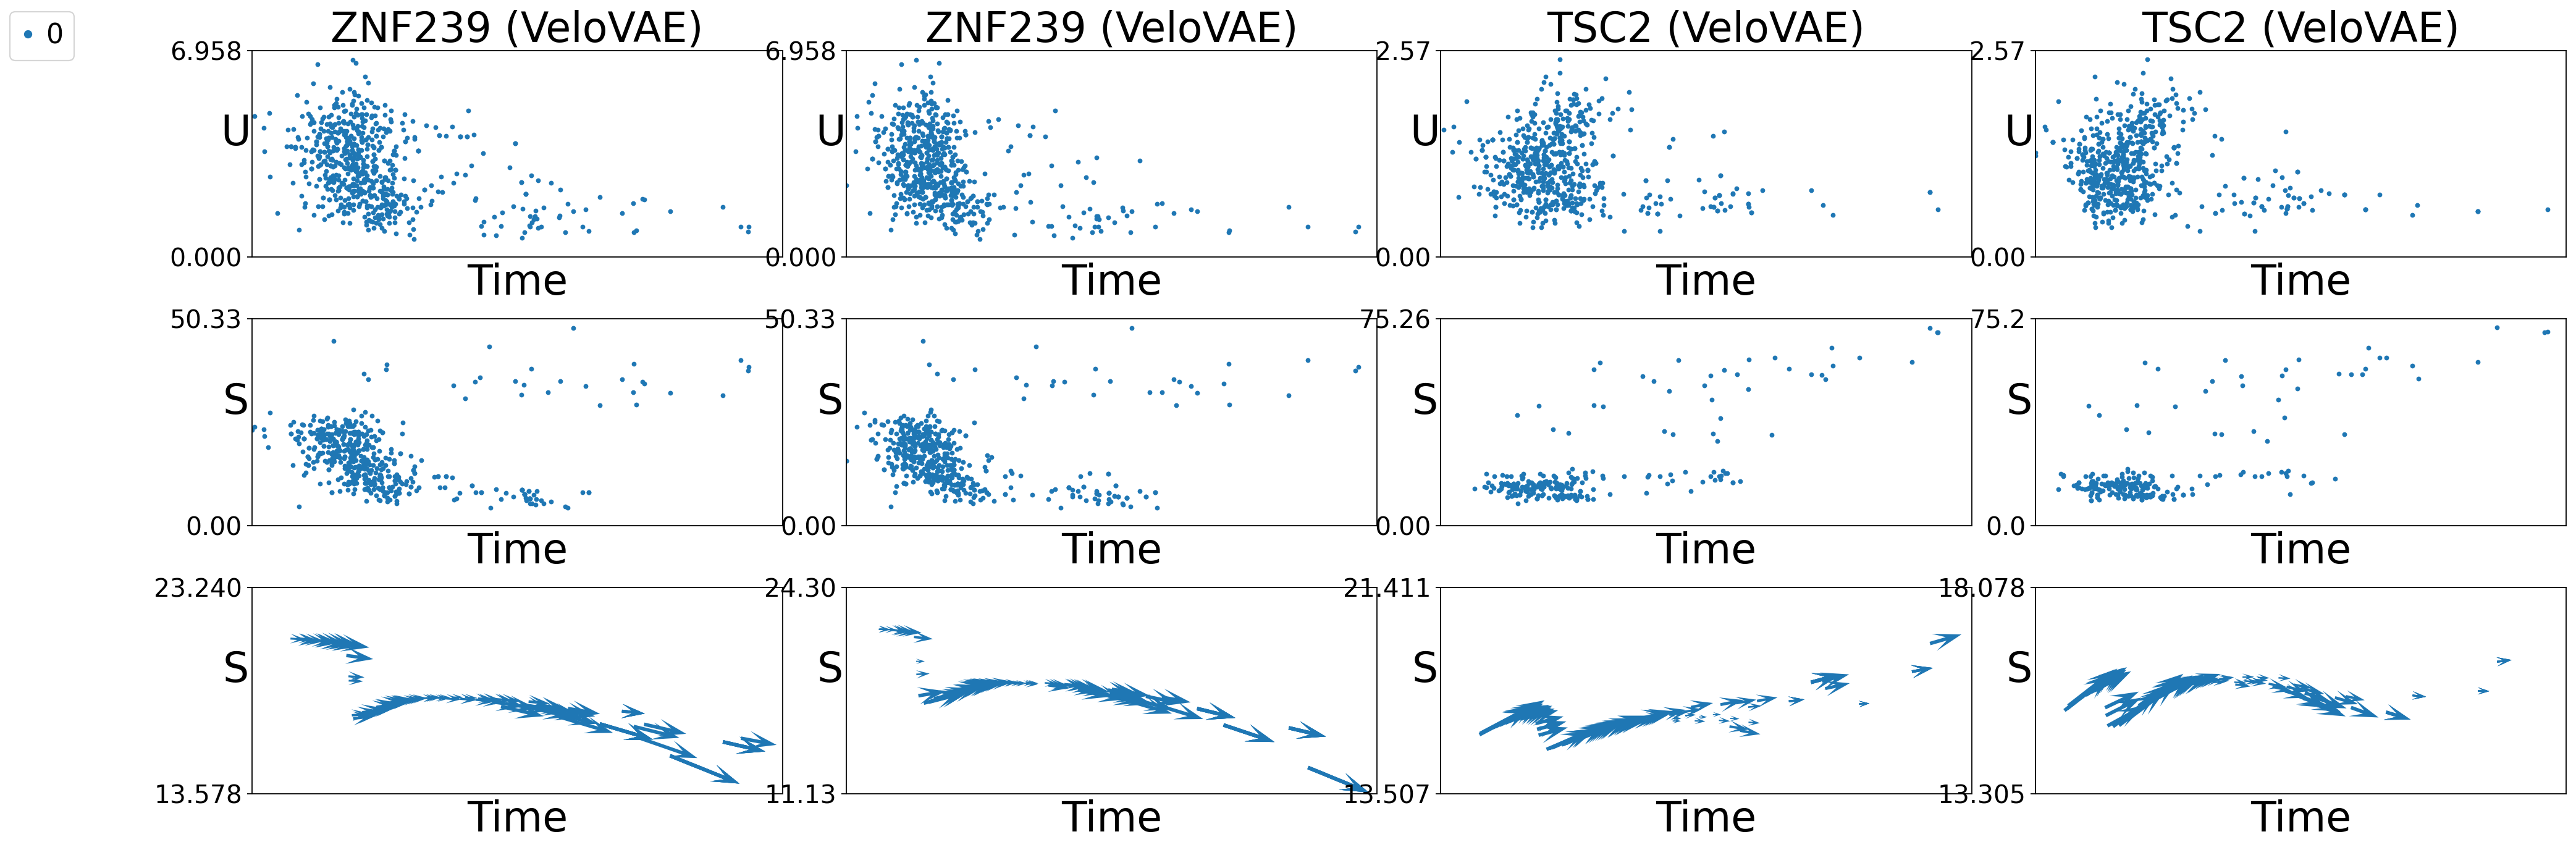

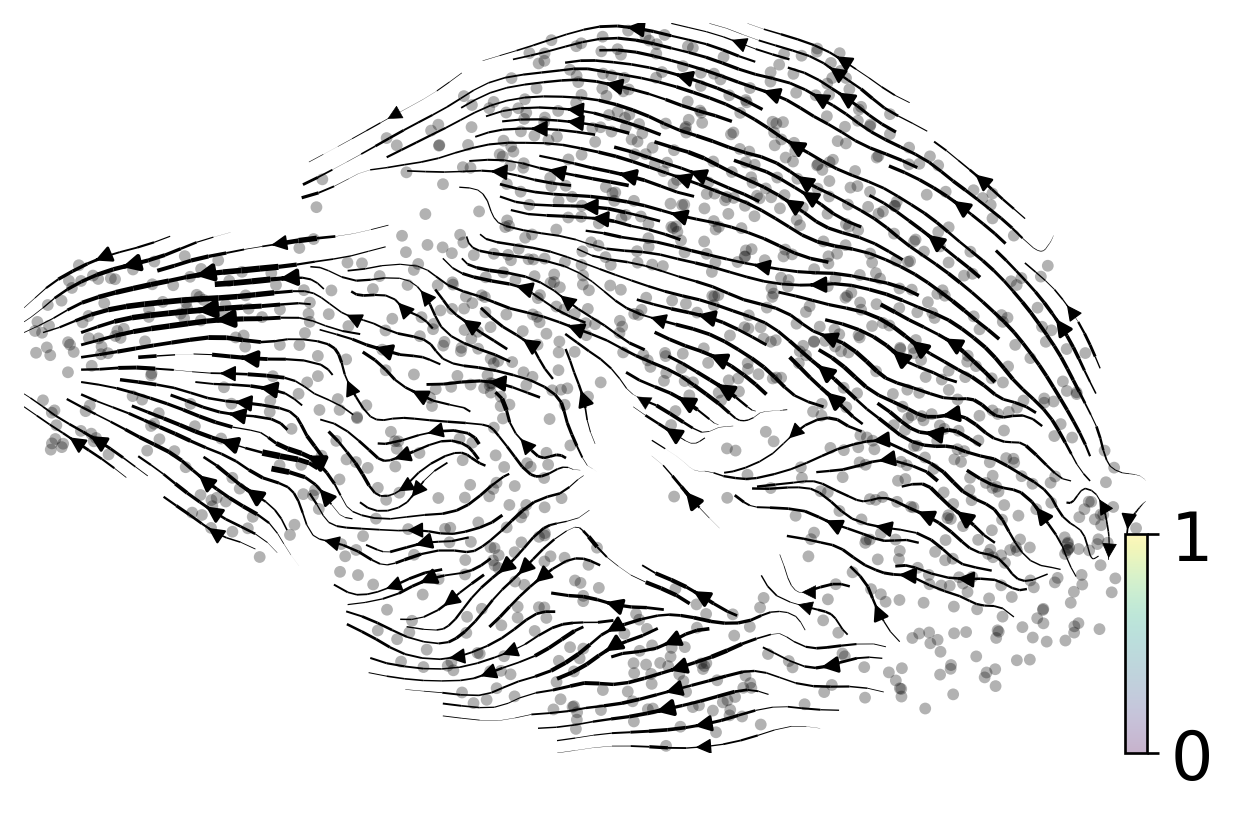

computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)


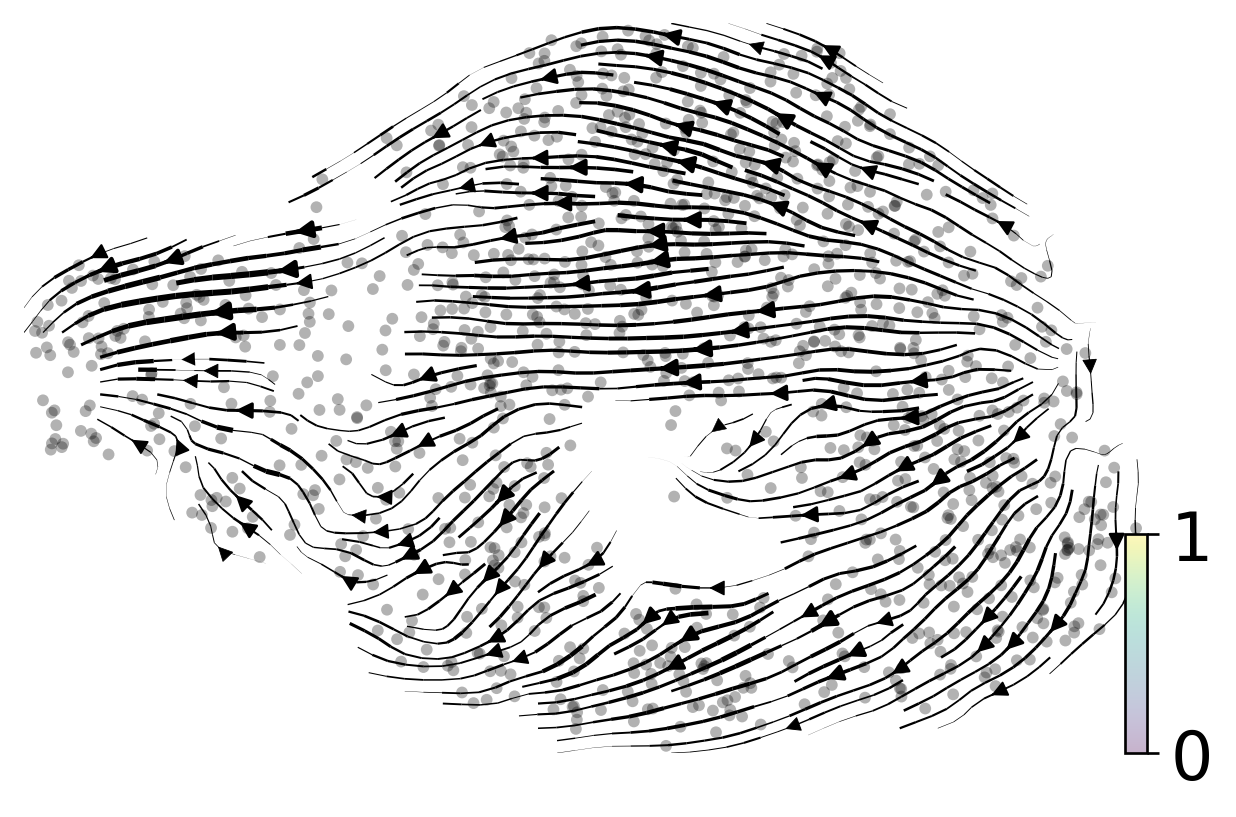

In [10]:
sc.tl.umap(adata)
adata.obs["clusters"] = "0"

methods = ['VeloVAE', 'FullVB']
keys = ['vae', 'fullvb']
grid_size = (1,2)
res, res_type = vv.post_analysis(adata,
                                 'continuous',
                                 methods,
                                 keys,
                                 compute_metrics=True,
                                 raw_count=False,
                                 genes=gene_plot,
                                 grid_size=(1,2))

In [11]:
adata

AnnData object with n_obs × n_vars = 1146 × 2000
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'vae_time', 'vae_std_t', 'vae_t0', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'clusters', 'vae_velocity_consistency', 'vae_velocity_self_transition', 'fullvb_velocity_consistency', 'fullvb_velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s', 'fullvb_logmu_alpha', 'fullvb_logmu_beta', 'fullvb_logmu_gamma', 'fullvb_logstd_alpha', 'fullvb_logstd_beta', 'fullvb_logstd_gamma', 'fullvb_ton', 'fullvb_scaling', 'fullvb_sigma_u', 'fullvb_sigma_s', 'vae_mse_train', 'vae_mse_test', 'vae_mae_train', 'vae_mae_test', 'vae_likelihood_train', 'vae_likelihoo

In [12]:
adata.write('velovae_cycle.h5ad')